### Cross-validation
This notebook demonstrates an appropriate strategy for using cross-validation to evaluate machine learning model performance.  We utilize the strategies described in [Practically Significant Method Comparison Protocols for Machine Learning in Small Molecule Drug Discovery](https://pubs.acs.org/doi/10.1021/acs.jcim.5c01609)

We begin by installing the necessary Python libraries. 

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    from IPython import get_ipython
    # only install packages if running in Google Colab
    get_ipython().run_line_magic('pip', 'install pandas matplotlib seaborn lightgbm scikit-learn tqdm statsmodels useful_rdkit_utils')

When performing cross-validation, it's important to prevent similar molecular structures from appearing in both the training and test sets to avoid data leakage and overestimating model performance. One effective strategy is to cluster the compounds and ensure that each cluster is assigned exclusively to either the training or the test set. Below, we use utility functions from [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils) to cluster the dataset using three different approaches, each grouping molecules into clusters in a different way.

In [4]:
import pandas as pd
import useful_rdkit_utils as uru
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import warnings
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

Read the input data. In this example we will use EC50 data for [Pregnane-X Receptor (PXR)](https://pubs.acs.org/doi/10.1021/acsmedchemlett.1c00187) agonism. The Pregnane-X Receptor (PXR) is a nuclear receptor that serves as a critical "xenobiotic sensor" in the body, functioning as a master regulator of drug metabolism and clearance. Because PXR has a notoriously large and flexible binding pocket that can accommodate a wide variety of structures, it is a common "anti-target" in early drug discovery. Teams frequently screen compounds to identify and filter out potent PXR activators to avoid these safety liabilities later in clinical trials.

In [5]:
chembl_df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/datafiles/refs/heads/main/PXR_chembl_EC50.csv")

Calculate RDKit descriptors

In [6]:
desc = uru.RDKitDescriptors()
chembl_df['desc'] = chembl_df.OPENADMET_CANONICAL_SMILES.apply(desc.calc_smiles)

In cross-validation, it's important to prevent similar molecular structures from appearing in both the training and test sets to avoid data leakage and overestimating model performance. One effective strategy is to cluster the compounds and ensure that each cluster is assigned exclusively to either the training or the test set. Below, we use utility functions from useful_rdkit_utils to cluster the dataset using three different approaches, each grouping molecules into clusters in a different way.
- *random* - puts each compound in its own cluster
- *scaffold* - uses the RDKit to decompose molecules into Bemis-Murcko clusters.  Each scaffold is then a distinct cluster. 
- *butina* - uses the RDKit to cluster compounds using the Butina algorithm. 

In [7]:
random_clusters = uru.get_random_clusters(chembl_df.OPENADMET_CANONICAL_SMILES)
scaffold_clusters = uru.get_bemis_murcko_clusters(chembl_df.OPENADMET_CANONICAL_SMILES)
butina_clusters = uru.get_butina_clusters(chembl_df.OPENADMET_CANONICAL_SMILES)

Build a list of clustering methods.

In [8]:
cluster_list = [random_clusters, scaffold_clusters, butina_clusters]
method_names = ["random","scaffold","butina"]

The function below performs nested cross-validation using GroupShuffleSplit to prevent similar groups (such as molecular clusters) from being present in both training and test sets. 
By default, it runs 5 repetitions of 5-fold cross-validation (5x5). 
Inputs:
   - A DataFrame containing the data.
   - A scikit-learn–compatible model.
   - The column names for descriptors/features (`X`) and activity/target (`y`).
   - A group label array indicating cluster membership for each compound.    
    
 This approach provides a more realistic assessment of model performance by minimizing information leakage due to structural similarity.

In [9]:
def cross_validate(
    df,
    model_in,
    X_col,
    y_col,
    group_labels,
    pbar_desc="",
    metric_list=None,
    n_outer=5,
    n_inner=5,
    test_size=0.2,
):
    """
    Run nested cross-validation using GroupShuffleSplit to ensure that similar groups (e.g., clusters) do not leak between train/test.
    
    Parameters:
        df: pd.DataFrame - The dataset.
        model_in: estimator - The estimator to fit.
        X_col: str - The feature column (containing numpy vectors).
        y_col: str - The target column.
        group_labels: list/array - Cluster or group assignment used for splitting.
        pbar_desc: str - Optional progress bar description.
        metric_list: list of callables - Scoring functions; defaults to [r2_score].
        n_outer: int - Number of outer iterations (CV repeats).
        n_inner: int - Number of splits per outer iteration.
        test_size: float - Test fraction for GroupShuffleSplit.

    Returns:
        result_list: list - Metric results, shape [n_outer * n_inner, len(metric_list)]
    """
    from sklearn.base import clone
    import warnings
    from tqdm.auto import tqdm
    import numpy as np

    if metric_list is None:
        from sklearn.metrics import r2_score
        metric_list = [r2_score]

    result_list = []
    y_arr = df[y_col].values
    X_vals = np.stack(df[X_col])
    for outer_idx in tqdm(range(n_outer), desc=pbar_desc):
        gss = GroupShuffleSplit(n_splits=n_inner, test_size=test_size, random_state=None)
        for train_idx, test_idx in gss.split(X_vals, y=y_arr, groups=group_labels):
            # Use index on the input df
            train = df.iloc[train_idx]
            test = df.iloc[test_idx]

            model = clone(model_in)
            model.fit(np.stack(train[X_col]), train[y_col].values)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                pred = model.predict(np.stack(test[X_col]))

            results_row = []
            for metric in metric_list:
                try:
                    results_row.append(metric(test[y_col].values, pred))
                except Exception as e:
                    results_row.append(np.nan)
                    print(f"Warning: Metric {metric.__name__} failed: {e}")
            result_list.append(results_row)

    return result_list

Next, we will perform cross-validation using each of the three data splitting strategies. The example below uses `LGBMRegressor`, but you can substitute any regressor that is compatible with scikit-learn. We define `metric_list` to specify which evaluation metrics to calculate during validation. For each splitting strategy, the resulting scores along with their associated method names are collected and stored in the `split_score_df_list`.

In [10]:
current_model = LGBMRegressor(verbose=-1)
metric_list = [r2_score,mean_absolute_error]
metric_names = ["R2","MAE"]
split_score_df_list = []
for cluster,method_name in zip(cluster_list,method_names):
    split_score_list = cross_validate(chembl_df,current_model,"desc","PXR_pEC50",cluster,method_name,metric_list)
    split_score_df = pd.DataFrame(split_score_list,columns=metric_names)
    split_score_df['method'] = method_name
    split_score_df_list.append(split_score_df)

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

Combine the results into a single DataFrame for easier comparison.

In [11]:
split_combo_df = pd.concat(split_score_df_list)

Plot $R^2$ and MAE as box plots.  Note that random splits and Butina splits tend to provide upper and lower bounds for model performance. 

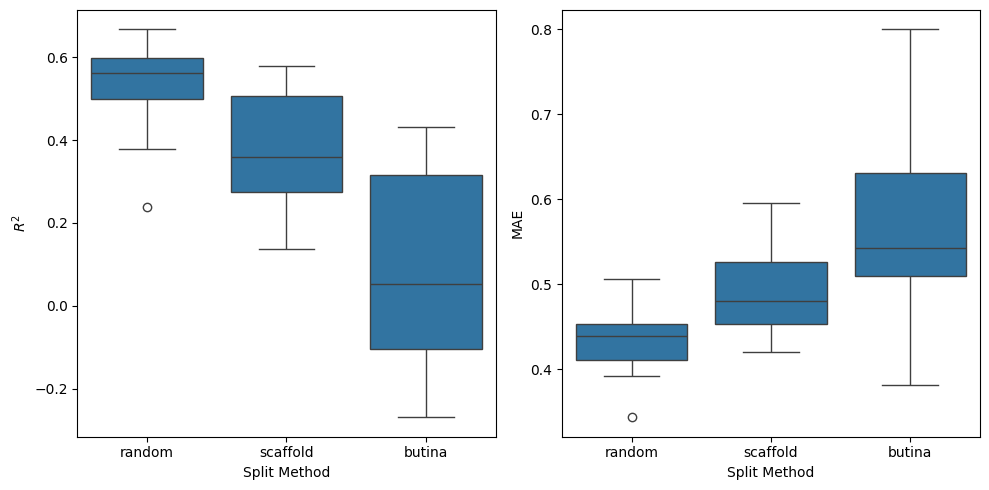

In [12]:
figure, axes = plt.subplots(1,2,figsize=(10,5))
ax_0 = sns.boxplot(x="method",y="R2",data=split_combo_df,ax=axes[0])
ax_0.set_xlabel("Split Method")
ax_0.set_ylabel("$R^2$")
ax_1 = sns.boxplot(x="method",y="MAE",data=split_combo_df,ax=axes[1])
ax_1.set_xlabel("Split Method")
plt.tight_layout()

[Tukey's Honest Significant Difference (HSD) test](https://en.wikipedia.org/wiki/Tukey%27s_range_test) allows us to evaluate whether there are statistically significant differences in model performance between the different data splitting methods. The table below summarizes the mean difference between each pair of methods (meandiff), the p-value adjusted for multiple comparisons (p-adj), the confidence interval boundaries, and whether the null hypothesis of equal means can be rejected (reject). The results indicate a signficant difference between the three splitting strategies.

In [13]:
tukey_r2 = pairwise_tukeyhsd(endog=split_combo_df["R2"], groups=split_combo_df["method"], alpha=0.05)
print(tukey_r2)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
butina   random   0.4533    0.0  0.3457   0.561   True
butina scaffold   0.3016    0.0  0.1939  0.4093   True
random scaffold  -0.1517 0.0034 -0.2594 -0.0441   True
------------------------------------------------------


We can use the same method to compare the MAE results.  In this case, all the differences are significant. 

In [14]:
tukey_mae = pairwise_tukeyhsd(endog=split_combo_df["MAE"], groups=split_combo_df["method"], alpha=0.05)
print(tukey_mae)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
butina   random  -0.1328    0.0 -0.1781 -0.0875   True
butina scaffold  -0.0773 0.0003 -0.1226  -0.032   True
random scaffold   0.0556 0.0123  0.0103  0.1009   True
------------------------------------------------------


Define a small function to calculate an Analysis of Variance (ANOVA) on a dataframe.

In [15]:
def run_anova(df_in, col, group_var="method"):
    res_list = []
    for k,v in df_in.groupby(group_var):
        res_list.append(v[col].values)
    return f_oneway(*res_list)[1]

Find the splitting method that yielded the highest $R^2$ and lowest MAE.

In [16]:
best_r2 = split_combo_df.groupby("method").mean().reset_index().sort_values("R2",ascending=False).method.values[0]
best_mae = split_combo_df.groupby("method").mean().reset_index().sort_values("MAE",ascending=True).method.values[0]
best_r2,best_mae

('random', 'random')

The plot below is one of my favorites. It shows the mean value for each splitting method along with the associated confidence interval.  The colors in the plot designate statistical significance and priority.  
- The best method is shown in blue. 
- When a value is shown in grey, we **cannot** reject the null hypothesis that the mean is equivalent to the value in blue.
- When a value is shown in red, we **can** reject the null hypothesis that the mean is equivalent to the value in blue. 

Text(0.5, 1.0, 'ANOVA p=6.27e-09')

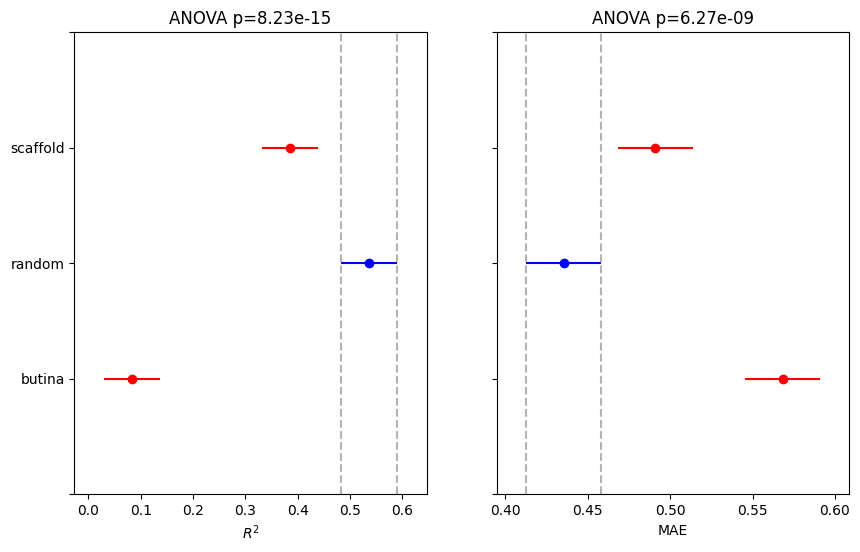

In [17]:
figure, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
tukey_r2.plot_simultaneous(comparison_name=best_r2,ax=axes[0])
r2_anova = run_anova(split_combo_df,"R2","method")
axes[0].set_xlabel("$R^2$")
axes[0].set_title(f"ANOVA p={r2_anova:.2e}")
tukey_mae.plot_simultaneous(comparison_name=best_r2,ax=axes[1])
axes[0].set_xlabel("$R^2$")
axes[1].set_xlabel("MAE")
mae_anova = run_anova(split_combo_df,"MAE","method")
axes[1].set_title(f"ANOVA p={mae_anova:.2e}")

Now let's use the same cross-validation function to compare machine learning algorithms.  To keep things simple we'll use scaffold splitting with three different regression models.
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) - very fast
- [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) - not so fast
- [HistGradientBoosting](https://scikit-learn.org/stable/auto_examples/ensemble/plot_hgbt_regression.html#) - kinda fast


To begin, we'll create two lists: one of regressors and another of their corresponding names.  Note that I supplied arguments to the constructors to eliminate verbose output. 

In [19]:
model_list = [LGBMRegressor(verbose=-1),RandomForestRegressor(),HistGradientBoostingRegressor()]
model_names = ["LGBM","RF","HGBR"]

Loop over all the classifiers and compare the results of 5x5 cross-validation for each model. The model stats are stored in a dataframe and the dataframes are combined to show the comparative results. 

In [20]:
model_score_df_list = []
for model, model_name in zip(model_list, model_names):
    model_score_list = cross_validate(chembl_df,model,"desc","PXR_pEC50",scaffold_clusters,model_name,metric_list)
    model_score_df = pd.DataFrame(model_score_list,columns=metric_names)
    model_score_df['model'] = model_name
    model_score_df_list.append(model_score_df)

LGBM:   0%|          | 0/5 [00:00<?, ?it/s]

RF:   0%|          | 0/5 [00:00<?, ?it/s]

HGBR:   0%|          | 0/5 [00:00<?, ?it/s]

Combine the model stats into a single dataframe. 

In [21]:
model_combo_df = pd.concat(model_score_df_list)

Plot $R^2$ and MAE as box plots. 

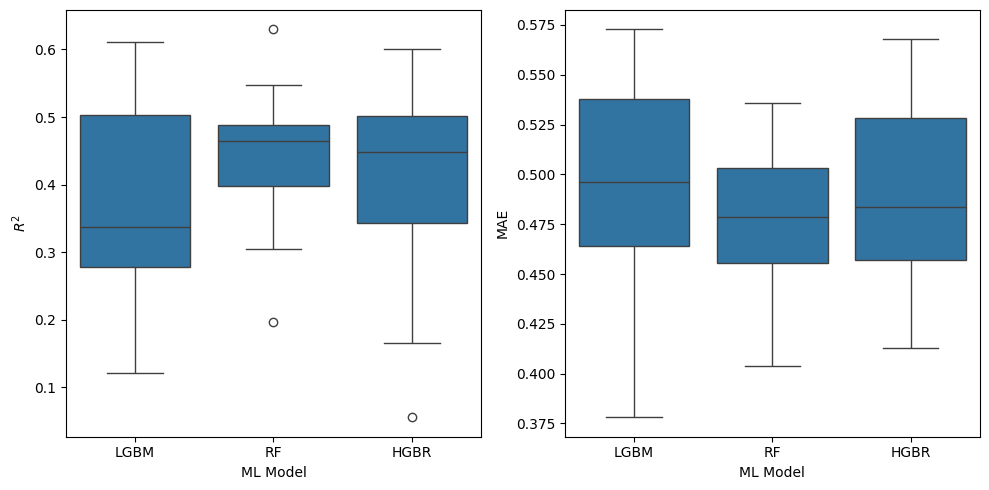

In [22]:
figure, axes = plt.subplots(1,2,figsize=(10,5))
ax_0 = sns.boxplot(x="model",y="R2",data=model_combo_df,ax=axes[0])
ax_0.set_xlabel("ML Model")
ax_0.set_ylabel("$R^2$")
ax_1 = sns.boxplot(x="model",y="MAE",data=model_combo_df,ax=axes[1])
ax_1.set_xlabel("ML Model")
plt.tight_layout()

Tukey HSD test was performed on the results from the three regressors. There is no significant difference for $R^2$. 

In [23]:
model_tukey_r2 = pairwise_tukeyhsd(endog=model_combo_df["R2"], groups=model_combo_df["model"], alpha=0.05)
print(model_tukey_r2)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  HGBR   LGBM  -0.0505 0.3259 -0.1345 0.0334  False
  HGBR     RF   0.0331 0.6154 -0.0509 0.1171  False
  LGBM     RF   0.0836 0.0513 -0.0004 0.1676  False
---------------------------------------------------


Tukey HSD test was performed on the results from the three regressors. There is no significant difference for MAE. 

In [24]:
model_tukey_mae = pairwise_tukeyhsd(endog=model_combo_df["MAE"], groups=model_combo_df["model"], alpha=0.05)
print(model_tukey_mae)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  HGBR   LGBM   0.0065 0.8527 -0.0225 0.0356  False
  HGBR     RF  -0.0112 0.6286 -0.0402 0.0179  False
  LGBM     RF  -0.0177 0.3162 -0.0468 0.0113  False
---------------------------------------------------


Determine the model with the highest $R^2$ and lowest MAE. 

In [25]:
model_best_r2 = model_combo_df.groupby("model").mean().reset_index().sort_values("R2",ascending=False).model.values[0]
model_best_mae = model_combo_df.groupby("model").mean().reset_index().sort_values("MAE",ascending=True).model.values[0]
model_best_r2,model_best_mae

('RF', 'RF')

Evaluate the statistical significance of the $R^2$ and MAE comparisons across the three models.

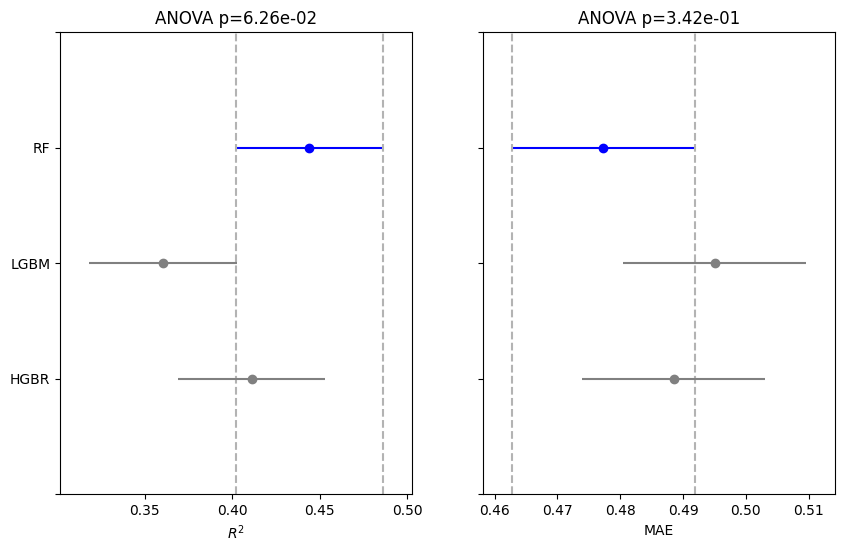

In [26]:
figure, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
model_tukey_r2.plot_simultaneous(comparison_name=model_best_r2,ax=axes[0])
r2_anova = run_anova(model_combo_df,"R2","model")
axes[0].set_xlabel("$R^2$")
axes[0].set_title(f"ANOVA p={r2_anova:.2e}")
model_tukey_mae.plot_simultaneous(comparison_name=model_best_mae,ax=axes[1])
axes[0].set_xlabel("$R^2$")
axes[1].set_xlabel("MAE")
mae_anova = run_anova(model_combo_df,"MAE","model")
axes[1].set_title(f"ANOVA p={mae_anova:.2e}");